In [1]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (497/497), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 497 (delta 372), reused 428 (delta 303), pack-reused 0
Receiving objects: 100% (497/497), 3.26 MiB | 18.34 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
from Eunomia.degree import *
from Eunomia.experiments import *
pyro.set_rng_seed(1)

In [232]:
N_CHAMBERS = 2

suffrages = np.random.randint(0,100,(N_CHAMBERS, N_PARTYS)).astype(float)

suffrages = np.array([
        np.array([100, 25, 15]),
        np.array([100, 15, 25]),
])

N_PARTYS = suffrages.shape[1]

def linear_scaling(x):
    return x / x.sum()

def pol_scaling(x , degree = 3):
    y = np.power(x, degree)
    return y / y.sum()


def scale(suffrages, scaling_functions):
    nsf = []
    for i in range(suffrages.shape[0]):
        nsf.append(scaling_functions[i](suffrages[i, :]))
    return np.array(nsf)

def evaluate_coalition(coalition, effectifs):
    return np.where(effectifs[:, coalition].sum(axis = 1) > 0.5)[0].shape[0]

def compute_data(n_partis, evaluation_function, effectifs):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,n_partis-1)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a), effectifs))
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    preferences = PreferenceModel(alternatives, ranks)
    data = preferences.generate_preference_matrix(theta)
    data = torch.tensor(data).float()
    return data ,theta


In [233]:
effectifs = scale(suffrages, [linear_scaling, linear_scaling])
data, theta = compute_data(effectifs.shape[1], evaluate_coalition,effectifs)
data

tensor([[-1.,  1.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0., -1.,  0.,  0.],
        [-1.,  1., -1.,  0., -1.,  0.],
        [-1.,  0.,  1.,  0.,  0.,  0.],
        [-1., -1.,  1., -1.,  0.,  0.],
        [-1.,  0.,  0.,  0., -1.,  0.],
        [-1.,  1.,  1.,  0.,  0.,  1.],
        [-1.,  0.,  1., -1.,  0.,  1.],
        [-1.,  1.,  0.,  0., -1.,  1.]])

In [234]:
sigma_w = 1e-1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [00:42, 58.31it/s, step size=2.23e-01, acc. prob=0.911]


(array([   6.,    2.,    3.,    4.,   18.,   23.,   25.,   69.,  178.,
        1172.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

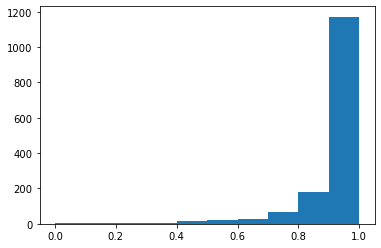

In [235]:
accs_d = get_acc_distribution(data, sampled_weights, sigmas)
plt.hist(accs_d)

In [236]:
svs = np.array([-compute_semivalues(N_PARTYS, theta, weights, lambda x:1)[::-1] for weights in sampled_weights])

In [241]:
means, stds = svs.mean(axis = 0), svs.std(axis = 0)

In [242]:
np.argsort(means)

array([0, 1, 2])

In [243]:
sampled_weights

tensor([[-0.1459,  0.0617,  0.1138,  0.0521, -0.1102, -0.0916],
        [-0.0937, -0.0704,  0.0497,  0.0229, -0.0653, -0.0128],
        [-0.1204,  0.0633,  0.0496, -0.1188, -0.0332,  0.1496],
        ...,
        [-0.0863,  0.0930,  0.0023, -0.0594, -0.0189, -0.1008],
        [-0.0828,  0.0588,  0.0444, -0.0028, -0.0188, -0.0510],
        [-0.0757,  0.0916, -0.0141, -0.1859, -0.0310,  0.0394]])

In [244]:
means

array([-0.11878509, -0.10445889,  0.69388994])